In [108]:
import numpy as np
import pandas as pd
from skimage.io import imread, imshow
!pip install periodictable
import periodictable

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from pathlib import Path
import re
import json
import matplotlib.pyplot as plt

In [0]:
from sklearn.linear_model import LinearRegression

In [89]:
# Only if on Google Colab

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [90]:
standards_df = pd.read_csv('https://raw.githubusercontent.com/HackTheSolarSystem/MineralMapping/master/challenge_data/mineral_standards.csv')
standards_df.head(5)

,Mg,Ni,Al,Fe,Ca,Cr,P,S,Ti,Si,mineral
0,0,0,0,0,171,0,4,0,459,0,CaTiO3std15
1,0,0,0,0,148,3,2,0,462,1,CaTiO3std15
2,0,2,0,0,141,6,3,0,455,2,CaTiO3std15
3,1,2,2,0,122,6,3,0,502,0,CaTiO3std15
4,0,0,0,0,138,5,5,0,457,1,CaTiO3std15


In [91]:
# Get expected standards weights 

rows = []
for filename in standards_df['mineral'].unique():
  try:
    formula = re.match(r'([A-Za-z0-9]*).*(std)(.*)', filename).groups()[0]
    weights = periodictable.formula(formula).mass_fraction
    weights = dict((str(e), w) for e,w in weights.items())
    weights['mineral_formula'] = formula
    weights['mineral'] = filename
    rows.append(weights)
  except:
    print(filename)

# rutile
weights = periodictable.formula('TiO2').mass_fraction
weights = dict((str(e), w) for e,w in weights.items())
weights['mineral_formula'] = 'TiO2'
weights['mineral'] = 'rutile'
rows.append(weights)

# SCOlv
rows.append({
    'mineral': 'SCOlvstd6', 'mineral_formula': '???', 
    'Si': .1908, 'Fe': .0742, 'Mg': .298, 'Mn': .0011, 'Ca': .0002, 'Ni': .0029
})  
  
weights_df = pd.DataFrame.from_records(rows).fillna(0)
weights_df.columns = [str(i) + '_weight' if str(i)[0].isupper() else str(i) for i in weights_df.columns]


standards_df = standards_df.merge(weights_df, on='mineral')
standards_df.head()

rutile
SCOlvstd6


,Mg,Ni,Al,Fe,Ca,Cr,P,S,Ti,Si,...,Ca_weight,Fe_weight,Mg_weight,Mn_weight,Ni_weight,O_weight,S_weight,Si_weight,Ti_weight,mineral_formula
0,0,0,0,0,171,0,4,0,459,0,...,0.294814,0.0,0.0,0.0,0.0,0.353075,0.0,0.0,0.35211,CaTiO3
1,0,0,0,0,148,3,2,0,462,1,...,0.294814,0.0,0.0,0.0,0.0,0.353075,0.0,0.0,0.35211,CaTiO3
2,0,2,0,0,141,6,3,0,455,2,...,0.294814,0.0,0.0,0.0,0.0,0.353075,0.0,0.0,0.35211,CaTiO3
3,1,2,2,0,122,6,3,0,502,0,...,0.294814,0.0,0.0,0.0,0.0,0.353075,0.0,0.0,0.35211,CaTiO3
4,0,0,0,0,138,5,5,0,457,1,...,0.294814,0.0,0.0,0.0,0.0,0.353075,0.0,0.0,0.35211,CaTiO3


In [93]:
elements = {}

for col in ['Mg', 'Ni', 'Al', 'Fe', 'Ca', 'Cr', 'P', 'S', 'Ti', 'Si']:
  try:
    x = standards_df['%s_weight' % col].reshape(-1,1)
    y = standards_df[col]
    
    m = LinearRegression()
    m.fit(x,y)
    print(col, m.coef_[0], m.intercept_)
    d = {
        'element': col,
        'coef': m.coef_[0],
        'intercept': m.intercept_,
        'std': standards_df[standards_df['%s_weight' % col] > .01][col].std(),
        'noise': standards_df[standards_df['%s_weight' % col] == 0][col].std()
    }
    elements[col] = d
  except:
    pass

Mg 840.1532511324668 0.1436064531510226
Ni 302.0864913360913 0.5339756727391531
Fe 311.4356452476751 -0.18536195985906545
Ca 461.2234598579972 0.28230528466584914
S 210.310447449412 0.01002271126765919
Ti 1279.045019042139 3.850835728870237
Si 1012.3924348641195 0.8699038385122613


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: F

In [37]:
elements

{'Ca': {'coef': 461.2234598579972,
  'element': 'Ca',
  'intercept': 0.28230528466584914,
  'noise': 0.7839330547099527,
  'std': 11.257305019123955},
 'Fe': {'coef': 311.4356452476751,
  'element': 'Fe',
  'intercept': -0.18536195985906545,
  'noise': 1.1155958908410166,
  'std': 106.4856160349156},
 'Mg': {'coef': 840.1532511324668,
  'element': 'Mg',
  'intercept': 0.1436064531510226,
  'noise': 0.4296300849187811,
  'std': 13.785308695058726},
 'Ni': {'coef': 302.0864913360913,
  'element': 'Ni',
  'intercept': 0.5339756727391531,
  'noise': 1.329300610782946,
  'std': 52.85466500629178},
 'S': {'coef': 210.310447449412,
  'element': 'S',
  'intercept': 0.01002271126765919,
  'noise': 0.16686134572121558,
  'std': 8.823133419855987},
 'Si': {'coef': 1012.3924348641195,
  'element': 'Si',
  'intercept': 0.8699038385122613,
  'noise': 1.2343527334863502,
  'std': 12.817817389598126},
 'Ti': {'coef': 1279.045019042139,
  'element': 'Ti',
  'intercept': 3.850835728870237,
  'noise': 2.

In [0]:
#targets = ['']


#to_dict(periodictable.formula('NiS').mass_fraction)

targets = [
    {'type': 'formula', 'formula': 'NiS', 'name': 'Millerite'},
    {'type': 'formula', 'formula': 'FeS', 'name': 'Troilite'},
    {'type': 'formula', 'formula': 'FeNiS', 'name': 'Pentlandite'},
    {'type': 'formula', 'formula': 'Ca2Si2O6', 'name': 'Ca2Si2O6'},
    {'type': 'formula', 'formula': 'CaAl2Si2O8', 'name': 'CaAl2Si2O8'},
    {'type': 'formula', 'formula': 'CaMgSi2O6', 'name': 'Diopside'},
    {'type': 'formula', 'formula': 'NaAlSi3O8', 'name': 'Albite'},
    {'type': 'variable', 'name': 'Olivine', 'formula': [
        {'type': 'choice', 'elements': [('Fe', (0, 1)), ('Mg', (0, 1))], 'quantity': 2},
        {'type': 'fixed', 'elements': 'SiO4'}
    ]},
    {'type': 'variable', 'name': 'Pyroxene', 'formula': [
        {'type': 'choice', 'elements': [('Fe', (0, 1)), ('Mg', (0, 1))], 'quantity': 1},
        {'type': 'fixed', 'elements': 'SiO3'}
    ]},
    {'type': 'variable', 'name': 'Taenite', 'formula': [
        {'type': 'choice', 'elements': [('Fe', (.5, .6)), ('Ni', (.4, .5))], 'quantity': 1},
    ]},
    {'type': 'variable', 'name': 'Kamacite', 'formula': [
        {'type': 'choice', 'elements': [('Fe', (.9, .9)), ('Ni', (.1, .1))], 'quantity': 1},
    ]}
    
]

In [48]:
:periodictable.elements.Fe.mass, periodictable.elements.S.mass, periodictable.formula('FeS').mass_fraction, 55.845/(55.845 + 32.065)

(55.845,
 32.065,
 {Fe: 0.6352519622341031, S: 0.3647480377658969},
 0.6352519622341031)

In [73]:
np.random.uniform(.9,.9)

0.9

In [58]:
q = periodictable.formula('FeS')
q.mass_fraction

def get_formula_weights(formula):
  f = periodictable.formula(formula)
  mass = f.mass
  fractions = f.mass_fraction
  
  return dict([(str(e), mass*f) for e,f in fractions.items()])

get_formula_weights('FeS')

{'Fe': 55.845, 'S': 32.065}

In [96]:
def to_dict(d):
  return dict([(str(e), w) for e,w in d.items()])

def get_formula_weights(formula):
  f = periodictable.formula(formula)
  mass = f.mass
  fractions = f.mass_fraction
  
  return dict([(str(e), mass*f) for e,f in fractions.items()])

def get_formula_percents(formula):
  return to_dict(periodictable.formula(formula).mass_fraction)

def get_variable_percents(formula):
  weights = {}
  
  def add_weight(element, mass):
    if element in weights:
      weights[element] += mass
    else:
      weights[element] = mass
  
  for component in formula:
    if component['type'] == 'choice':
      elements = component['elements']
      interval = elements[0][1]
      frac = np.random.uniform(*interval)
      add_weight(
          elements[0][0],
          periodictable.formula(elements[0][0]).mass * frac * component['quantity']
      )
      add_weight(
          elements[1][0],
          periodictable.formula(elements[1][0]).mass * (1 - frac) * component['quantity']
      )
    elif component['type'] == 'fixed':
      for e,m in get_formula_weights(component['elements']).items():
        add_weight(e,m)
  
  total = sum(weights.values())
  
  return dict([(e, m/total) for e,m in weights.items()])
      

def simulate_mineral(name, weights):
  intensities = {'mineral': name}
  for e in elements.values():
    v = e['intercept']
    v += np.random.normal(scale=e['noise'])
    if e['element'] in weights:
      v += e['coef']*weights[e['element']]
      v += np.random.normal(scale=e['std'])
      
    v = int(np.clip(v, 0, None))
    intensities[e['element']] = v

  return intensities
  
'''for t in targets:
  if t['type'] == 'formula':
    print(simulate_mineral(t['name'], get_formula_percents(t['formula'])))
  elif t['type'] == 'variable':
    for i in range(5):
      print(simulate_mineral(t['name'], get_variable_percents(t['formula'])))'''


{'mineral': 'Millerite', 'Mg': 0, 'Ni': 235, 'Fe': 0, 'Ca': 0, 'S': 77, 'Ti': 3, 'Si': 0}
{'mineral': 'Troilite', 'Mg': 0, 'Ni': 0, 'Fe': 161, 'Ca': 1, 'S': 86, 'Ti': 0, 'Si': 0}
{'mineral': 'Pentlandite', 'Mg': 0, 'Ni': 109, 'Fe': 0, 'Ca': 0, 'S': 49, 'Ti': 5, 'Si': 0}
{'mineral': 'Ca2Si2O6', 'Mg': 0, 'Ni': 1, 'Fe': 0, 'Ca': 155, 'S': 0, 'Ti': 4, 'Si': 247}
{'mineral': 'CaAl2Si2O8', 'Mg': 0, 'Ni': 2, 'Fe': 0, 'Ca': 68, 'S': 0, 'Ti': 1, 'Si': 196}
{'mineral': 'Olivine', 'Mg': 85, 'Ni': 0, 'Fe': 28, 'Ca': 0, 'S': 0, 'Ti': 3, 'Si': 154}
{'mineral': 'Olivine', 'Mg': 131, 'Ni': 0, 'Fe': 5, 'Ca': 0, 'S': 0, 'Ti': 4, 'Si': 160}
{'mineral': 'Olivine', 'Mg': 162, 'Ni': 2, 'Fe': 74, 'Ca': 2, 'S': 0, 'Ti': 6, 'Si': 192}
{'mineral': 'Olivine', 'Mg': 222, 'Ni': 1, 'Fe': 33, 'Ca': 1, 'S': 0, 'Ti': 6, 'Si': 194}
{'mineral': 'Olivine', 'Mg': 182, 'Ni': 0, 'Fe': 139, 'Ca': 0, 'S': 0, 'Ti': 3, 'Si': 177}
{'mineral': 'Pyroxene', 'Mg': 45, 'Ni': 0, 'Fe': 26, 'Ca': 0, 'S': 0, 'Ti': 7, 'Si': 230}
{'mineral

In [0]:
samples = []

N = 10000
M = 10

for t in targets:
  if t['type'] == 'formula':
    for i in range(N):
      samples.append(simulate_mineral(t['name'], get_formula_percents(t['formula'])))
  elif t['type'] == 'variable':
    for i in range(int(N/M)):
      percents = get_variable_percents(t['formula'])
      for j in range(M):
        samples.append(simulate_mineral(t['name'], percents))

In [113]:
samples_df = pd.DataFrame.from_records(samples)
samples_df.head()

,Ca,Fe,Mg,Ni,S,Si,Ti,mineral
0,0,0,0,181,88,0,2,Millerite
1,0,0,0,167,81,1,4,Millerite
2,0,0,0,167,77,1,5,Millerite
3,1,0,0,222,75,1,4,Millerite
4,0,0,0,158,66,1,9,Millerite


In [0]:
samples_df.to_csv('simulated_mineral_samples_3.csv', index=False)

In [0]:
X = samples_df[['Ca', 'Fe', 'Mg', 'Ni', 'S', 'Si', 'Ti']].values
Y = samples_df['mineral']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2)

In [116]:
#mod = SVC(kernel='rbf', max_iter=300)
mod = RandomForestClassifier(100, max_depth=5, n_jobs=-1)
mod.fit(X_train, Y_train)
(mod.predict(X_train) == Y_train).mean(), (mod.predict(X_test) == Y_test).mean()

(0.9685681818181818, 0.9674545454545455)

In [0]:
# Define where your images are

root = Path('gdrive/My Drive/meteorite_mineral_mapper')
image_path = root / 'dataset_1_opaques'

In [120]:
images = [{'element': s.name.split('_')[2].split('.')[0], 'image': imread(s)} for s in image_path.glob('obj2_32bt_*')]
images

[{'element': 'Al', 'image': array([[ 9, 12,  3, ...,  0,  5,  7],
         [15, 12,  7, ...,  4,  3,  2],
         [13, 15, 11, ...,  3,  4,  3],
         ...,
         [ 0,  0,  0, ..., 10,  8,  3],
         [ 0,  2,  2, ..., 10,  9,  5],
         [ 0,  0,  0, ..., 14,  6,  4]], dtype=int32)},
 {'element': 'Ca', 'image': array([[12, 12, 11, ...,  5,  4, 12],
         [ 4,  4, 15, ...,  4,  8,  0],
         [ 6,  6, 18, ...,  5,  3,  7],
         ...,
         [ 0,  3,  0, ..., 10,  7,  4],
         [ 0,  0,  0, ...,  3,  7,  2],
         [ 2,  0,  2, ...,  7,  3,  3]], dtype=int32)},
 {'element': 'Cr', 'image': array([[ 5, 10,  9, ...,  7, 12, 12],
         [ 6,  3,  7, ..., 17, 10, 15],
         [14, 12,  3, ..., 12,  6, 20],
         ...,
         [11,  7,  8, ..., 11, 10, 10],
         [10,  5, 12, ...,  6,  5, 11],
         [ 7, 13,  7, ...,  7,  6, 11]], dtype=int32)},
 {'element': 'Fe', 'image': array([[49, 44, 45, ..., 19, 21, 17],
         [38, 42, 48, ..., 11, 17, 23],
      

In [121]:
columns = []
pixels = []
for element in images:
  columns.append(element['element'])
  pixels.append(element['image'].flatten())
  
image_pixels_df = pd.DataFrame(np.dstack(pixels)[0], columns=columns)
image_pixels_df = image_pixels_df.reset_index().rename(columns={'Pho': 'P', 'Sul': 'S', 'index': 'order'})
image_pixels_df.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti
0,0,9,12,5,49,66,2,0,0,330,3
1,1,12,12,10,44,76,0,0,0,226,0
2,2,3,11,9,45,90,2,3,0,221,0
3,3,0,12,10,53,105,0,0,0,205,4
4,4,2,5,11,41,85,0,0,0,224,3


In [0]:
X = image_pixels_df[['Ca', 'Fe', 'Mg', 'Ni', 'S', 'Si', 'Ti']].values
image_pixels_df['predicted_element'] = mod.predict(X)

In [123]:

results = image_pixels_df.merge(
    pd.Series(mod.classes_, name='predicted_element').reset_index().rename(columns={'index': 'element_index'}),
    on='predicted_element'
).sort_values('order')
results.head()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,S,Si,Ti,predicted_element,element_index
0,0,9,12,5,49,66,2,0,0,330,3,Pyroxene,8
1,1,12,12,10,44,76,0,0,0,226,0,Pyroxene,8
2,2,3,11,9,45,90,2,3,0,221,0,Pyroxene,8
30028,3,0,12,10,53,105,0,0,0,205,4,Olivine,6
3,4,2,5,11,41,85,0,0,0,224,3,Pyroxene,8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


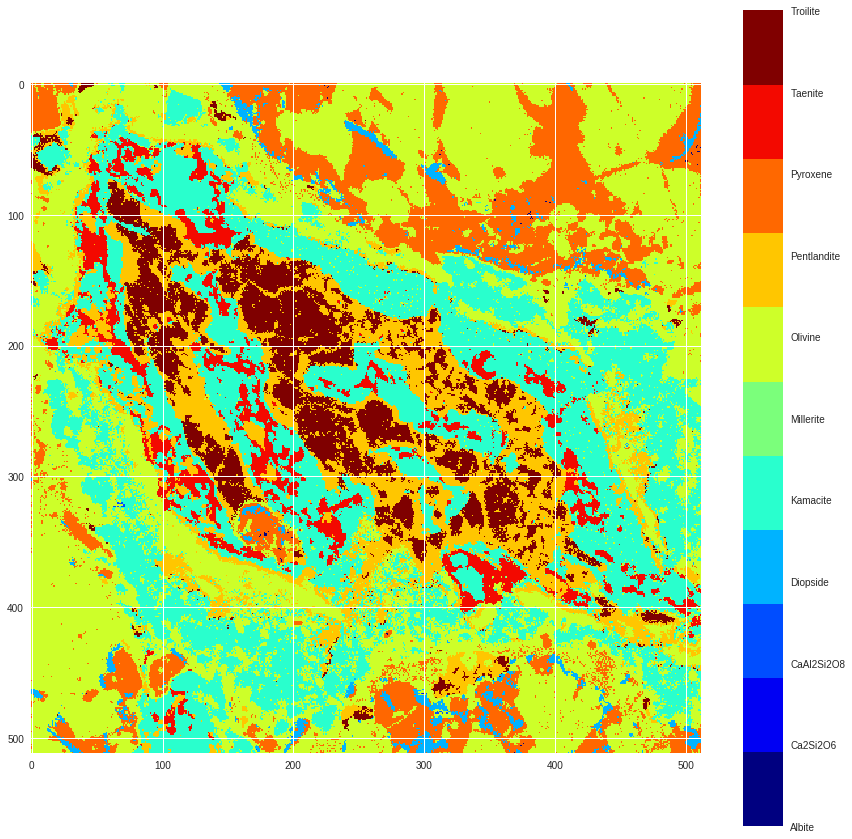

In [124]:
figure, ax = plt.subplots(figsize=(15,15))
i = ax.imshow(
    results['element_index'].reshape((512, 512)),
    cmap=plt.cm.get_cmap('jet', len(mod.classes_))
)
cbar = figure.colorbar(i, ticks=range(len(mod.classes_)))
cbar.ax.set_yticklabels(mod.classes_)
ax.legend()

In [110]:
results.groupby('predicted_element').count()

,order,Al,Ca,Cr,Fe,Mg,Ni,P,Si,S,Ti,element_index
predicted_element,,,,,,,,,,,,
Ca2Si2O6,1,1,1,1,1,1,1,1,1,1,1,1
CaAl2Si2O8,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064,2064
Kamacite,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000,42000
Olivine,108295,108295,108295,108295,108295,108295,108295,108295,108295,108295,108295,108295
Pentlandite,30893,30893,30893,30893,30893,30893,30893,30893,30893,30893,30893,30893
Pyroxene,73632,73632,73632,73632,73632,73632,73632,73632,73632,73632,73632,73632
Taenite,3828,3828,3828,3828,3828,3828,3828,3828,3828,3828,3828,3828
Troilite,1431,1431,1431,1431,1431,1431,1431,1431,1431,1431,1431,1431
